# Table of contents
0. [Introduction](0-Introduction.ipynb)
1. [Variables](1-Variables.ipynb)
2. [Data structures](2-Data-Structures.ipynb)
3. [Conditional statements and loops](3-Conditional-Statements-Loops.ipynb)
4. [Some exercises](4-Some-Exercises.ipynb)
5. [Introduction to functions](5-0-Introduction-function.ipynb)
    1. [File manipulation](5-1-File-manipulation.ipynb)
6. [From 0D to 1D](6-1-From-0D-to-1D.ipynb)
    1. [Adding lateral diffusion](6-2-Adding-lateral-diffusion.ipynb) $\leftarrow$
7. [From 1D to 2D](7-From-1D-to-2D.ipynb)
8. [Playing with the model](8-Playing-with-the-model.ipynb)

### 5.2 Adding lateral diffusion
Now, we are going to start doing real 1D!

The idea is that, up to now, we are able to have a row of cells that are acting next to each other but independently. We want to add to that the diffusion process of the Turing patterns: the $\mu_a\Delta a$ and $\mu_i\Delta i$.

We model the lateral diffusion for a given cell as simply as possible. The diffusion is a proportion (the parameters $\mu_a$ and $\mu_i$) of concentration that a cell receive from its direct neighbours minus what that cell gives to its neighbour, which is twice a given proportion of its own concentration (the proportion being $\mu_a$ for the activator and $\mu_i$ for the inhibitor).

Now, if $a_x$ is the activator concentration in the cell at the position $x$, we can formalise the previous sentence as follow:
$$
\mu_a\Delta a_x = \mu_a \frac{a_{x+\delta x} + a_{x-\delta x} - 2a_x}{\delta x}
$$

Therefore, after diffusion for a given time $\delta t$, the concentration $a_x$ is:
$$
a_{x, t+\delta t} = a_{x, t} + \delta t\mu_a\Delta a_{x,t} = a_{x,t} + \delta t\mu_a \frac{a_{x+\delta x, t} + a_{x-\delta x, t} - 2a_{x, t}}{\delta x}
$$
We tried to explain that with the following figure:
<img src="Images/Diffusion.png" alt="Diffusion" width="500"/>

Now that we have explained the theory (which might look a bit scary at first glance), let's see how we can implement that in practice.

As before, we need to compute the concentration of $A$ and $I$ for each cell.
The difference is that before it was only depending on what was in that cell, now it also depends on what was in the neighbouring cells.

Before (no neighbourhood interaction), i:
```python
A[i, t] = A[i, t-1] + dt * (A[i, t-1] - A[i, t-1]**3 - I[i, t-1] + k)
I[i, t] = I[i, t-1] + dt/tau * (A[i, t-1] - I[i, t-1])
```

After (with neighbourhood interaction):
```python
A[i, t] = A[i, t-1] + dt * (mu_a*(A[i-1, t-1] + A[i+1, t-1] - 2*A[i, t-1]) +\
                            A[i, t-1] - A[i, t-1]**3 - I[i, t-1] + k)
I[i, t] = I[i, t-1] + dt/tau * (mu_i*(I[i-1, t-1] + I[i-1, t+1] - 2*I[i, t-1]) +\
                                A[i, t-1] - I[i, t-1])
```

What it means in practice is that, to compute the concentration of the activator or the inhibitor for a given cell, not only we need to know what was happening at the previous time in that cell but we also need to know what was happening in the neighbouring cells.

### Exercise 14 (kind of a tough one 😨)

Because we are adding a new dimension to our problem, most of what we have developed until now becomes obsolete ...

This is because our two base functions (`da` and `di`) on which we built everything else do not take neighbouring cells as a parameter.

So ... we now have to rewrite the functions `da` and `di` so that they do take into account lateral diffusion. And because we are now a bit more advanced, we will write them into one function that takes as input a row of cells at $t$ and outputs the new row of cells at $t+\delta t$.

The function will therefore have the following header:
```python
def dA_I(A: np.array, I: np.array, dt: float, k: float, tau: float,
         dx: float, mu_a: float, mu_i: float) -> (np.array, np.array):
    new_A = np.zeros_like(A)
    new_I = np.zeros_like(I)
    ## Do the correct thing
    return new_A, new_I
```

In [7]:
# Usual reloading of all the previous libraries etc.

import numpy as np
from Resources.UsefulFunctions import *
from Resources.Answers import answer, hint

mu_a = 2.8e-4
mu_i = 5e-3
tau = .1
k = -.005
size = 100
dx = dy = 2. / size
T = 9.0
dt = .001
n = int(T / dt)

In [8]:
import numpy as np
tmp = np.arange(10)
print(tmp)
print(tmp[1:-1])
print(tmp[2:])
print(tmp[:-2])

[0 1 2 3 4 5 6 7 8 9]
[1 2 3 4 5 6 7 8]
[2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7]


In [9]:
np.random.seed(0)
A = np.random.random(100)
np.random.seed(1)
I = np.random.random(100)

def dA_I(A, I, dt, k, tau, dx, mu_a, mu_i):
    new_A = np.zeros_like(A)
    new_I = np.zeros_like(I)
    new_A[1:-1] = (A[1:-1] +
                   dt * (1/dx*mu_a*(A[:-2] + A[2:] - 2*A[1:-1]) + 
                         A[1:-1] - A[1:-1]**3 - I[1:-1] + k))
    new_A[0] = (A[0] +
                dt * (1/dx*mu_a*(A[1] - A[0]) + 
                      A[0] - A[0]**3 - I[0] + k))
    new_A[-1] = (new_A[-1] + 
                 dt * (dx*mu_a*(A[-2] - A[-1]) + 
                       A[-1] - A[-1]**3 - I[-1] + k))

    new_I[1:-1] = (I[1:-1] +
                   dt/tau * (1/dx*mu_i*(I[:-2] + I[2:] - 2*I[1:-1]) + 
                             A[1:-1] - I[1:-1]))
    new_I[0] = (I[0] + 
                dt/tau * (1/dx*mu_i*(I[1] - I[0]) + 
                          A[0] - I[0]))
    new_I[-1] = (I[-1] +  +
                 dt/tau * (1/dx*mu_i*(I[-2] - I[-1]) + 
                           A[-1] - I[-1]))
    return new_A, new_I

new_A, new_I = dA_I(A, I, dt=dt, k=k, tau=tau,
                    dx=dx, mu_a=mu_a, mu_i=mu_i)

In [10]:
## Checking wether your results are correct:
A_ans, I_ans = answer_results(14, A=A, I=I, dt=dt, k=k, tau=tau,
                              dx=dx, mu_a=mu_a, mu_i=mu_i)

if np.alltrue(A_ans==new_A) and np.alltrue(I_ans==new_I):
    print('My results are the same as what is expected')
elif np.allclose(A_ans, new_A) and np.allclose(I_ans, new_I):
    print('My results are all close to what is expected')
else:
    print('My results are different to what was expected')

My results are different to what was expected


Now, the function `dA_I` gives us the value of `A` and `I` from one time to the next with lateral diffusion.
The next step is to write a `for` loop that allows to compute our systems over all the necessary time-points.

### Exercise 15
Write a `for` loop that computes the concentration of a row of cells over `n` time-points.

In [11]:
A = np.zeros((size, n))
I = np.zeros((size, n))
np.random.seed(0)
A[:, 0] = np.random.random(100)
np.random.seed(1)
I[:, 0] = np.random.random(100)

for t in range(1, n):
    # do what is necessary
    A[:, t], I[:, t] = dA_I(A[:, t-1], I[:, t-1], dt=dt, k=k, tau=tau,
                            dx=dx, mu_a=mu_a, mu_i=mu_i)

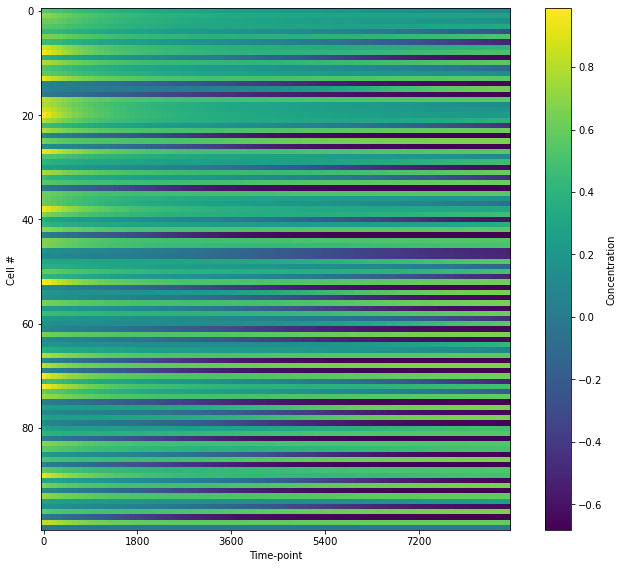

In [12]:
plot_concentration_1D(A, step=100)

While the result is different from what we had before, it is not by a lot.
We can now start playing with the parameters a little bit and check what would be happening to the oscillatory behaviour we found earlier:

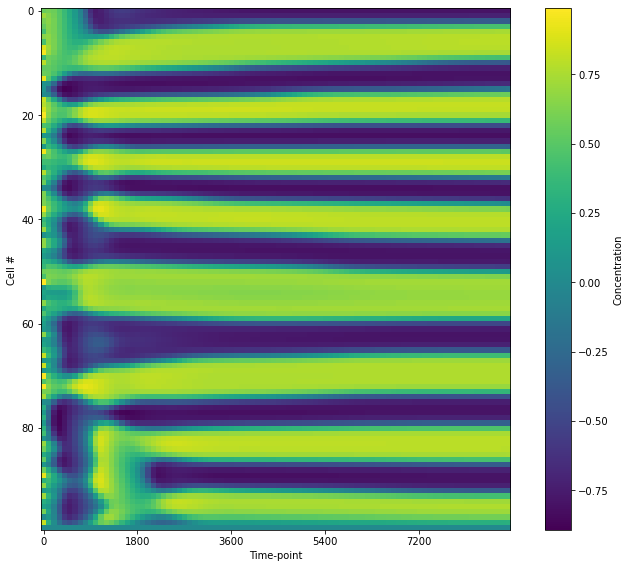

In [13]:
A = np.zeros((size, n))
I = np.zeros((size, n))
np.random.seed(0)
A[:, 0] = np.random.random(100)
np.random.seed(1)
I[:, 0] = np.random.random(100)

for t in range(1, n):
    # do what is necessary
    A[:, t], I[:, t] = dA_I(A[:, t-1], I[:, t-1], dt=.01, k=.05, tau=2,
                            dx=.0005, mu_a=mu_a, mu_i=mu_i)
plot_concentration_1D(A, step=100)

We can see the cells actually synchronising!

You can now play a bit more with the different parameters before starting the final part: the "real" Turing patterns, in 2D.

In [ ]:
# You can "play" here